<img src="https://gcgrossi.github.io/GiulioGrossi.png" width="20%">

# **_Giulio Cornelio Grossi, Ph.D._** 
_giulio.cornelio.grossi@gmail.com_

[![Linkedin](https://img.shields.io/badge/Linkedin-blue?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/in/giulio-cornelio-grossi/)
[![Github](https://img.shields.io/badge/Github-black?style=for-the-badge&logo=github)](https://github.com/gcgrossi)

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/118ZV814gCWS1PmJwXEQG0IoLoy0-Dcso?usp=sharing)

# **_Dowloads and Installs_**

In [2]:
print('\n Installing Tesseract ... \n')

# intstall pytesseract 
!pip install pytesseract
!apt install tesseract-ocr
!apt install libtesseract-dev

print('\n Cloning Github Repository ... \n')

# clone repository with datatset
!rm -r AMLD2021/
!git clone https://github.com/SamurAi-sarl/AMLD2021.git
!ls -ltr AMLD2021/*

print('\n Downloading example images ... \n')

#download relevant images
!curl -L "https://docs.google.com/uc?export=download&id=1Gu46DRx_idNbvjqHcuSKilX64v0DYNUJ" > transaction_ticket.jpg
!curl -L "https://docs.google.com/uc?export=download&id=1fKDIVs2JcGxe3i01RtPpDKIbKx1Oan7Z" > registration_ticket.jpg
!curl -L "https://docs.google.com/uc?export=download&id=19rjKuqF5s9AfAQiUt80RbLkQVP3oQZy9" > invoice_ticket.jpg
!curl -L "https://docs.google.com/uc?export=download&id=1UV4wnGKG3S5YU9PGesXcDJWrMLZIsK7z" > invoice_scanned.jpg
!curl -L "https://docs.google.com/uc?export=download&id=1i-HOc4VE0U2J-p1so5mhHAnc1e9rdaFR" > invoice_test_flash.jpg


 Installing Tesseract ... 

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=25f5f35cd81dccc4a1466bcb33654751bcc361b14cc9362ae4eb558f3c97f4ab
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe

# **_Imports_**

In [11]:
from google.colab import drive
from google.colab import files

from pathlib import Path

import pytesseract
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')
from pytesseract import Output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import shutil
import json
import cv2
import sys
import os


# **_Utilities Functions_** 

If you want to know more about under the hood function open this section.

### **_Four Point Transform_**

In [13]:
def order_points(pts):
  # initialzie a list of coordinates that will be ordered
  rect = np.zeros((4, 2), dtype = "float32")
  
  # the top-left point will have the smallest sum, whereas
  # the bottom-right point will have the largest sum
  s = pts.sum(axis = 1)
  rect[0] = pts[np.argmin(s)]
  rect[2] = pts[np.argmax(s)]
  
  # now, compute the difference between the points, the
  # top-right point will have the smallest difference,
  # whereas the bottom-left will have the largest difference
  diff = np.diff(pts, axis = 1)
  rect[1] = pts[np.argmin(diff)]
  rect[3] = pts[np.argmax(diff)]
  
  # return the ordered coordinates
  return rect

def four_point_transform(image, target, pts):
  # obtain a consistent order of the points and unpack them
  # individually
  rect = order_points(pts)
  (tl, tr, br, bl) = rect
  
  # use the target image shape as destination point of the transformation
  h, w, c = target.shape 
  dst = np.array([[0, 0],[w - 1, 0],[w - 1, h - 1],[0, h - 1]], dtype = "float32")
  
  # compute the perspective transform matrix and then apply it
  M = cv2.getPerspectiveTransform(rect, dst)
  warped = cv2.warpPerspective(image, M, (w, h))
  # return the warped image
  return warped

### **_Homographic Alignment_**

In [14]:
def align_images(image, template, maxFeatures=500, keepPercent=0.2,debug=False):
  
  # convert both the input image and template to grayscale
  imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
  
  # use ORB to detect keypoints and extract (binary) local
  # invariant features
  orb = cv2.ORB_create(maxFeatures)
  (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
  (kpsB, descsB) = orb.detectAndCompute(templateGray, None)
	
  # match the features
  method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
  matcher = cv2.DescriptorMatcher_create(method)
  matches = matcher.match(descsA, descsB, None)

  # sort the matches by their distance (the smaller the distance,
  # the "more similar" the features are)
  matches = sorted(matches, key=lambda x:x.distance)
	
  # keep only the top matches
  keep = int(len(matches) * keepPercent)
  matches = matches[:keep]

  # check to see if we should visualize the matched keypoints
  if debug:
    matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,matches, None)
    #matchedVis = imutils.resize(matchedVis, width=1000)

    #show the image
    #transform to RGB -> an OpenCV speciality
    plt.imshow(cv2.cvtColor(matchedVis, cv2.COLOR_BGR2RGB))

    #cv2.imshow("Matched Keypoints", matchedVis)
    #cv2.waitKey(0)

  # allocate memory for the keypoints (x, y)-coordinates from the
  # top matches -- we'll use these coordinates to compute our
  # homography matrix
  ptsA = np.zeros((len(matches), 2), dtype="float")
  ptsB = np.zeros((len(matches), 2), dtype="float")
  
  # loop over the top matches
  for (i, m) in enumerate(matches):
    # indicate that the two keypoints in the respective images
    # map to each other
    ptsA[i] = kpsA[m.queryIdx].pt
    ptsB[i] = kpsB[m.trainIdx].pt

  # compute the homography matrix between the two sets of matched
  # points
  (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
  # use the homography matrix to align the images
  (h, w) = template.shape[:2]
  aligned = cv2.warpPerspective(image, H, (w, h))
  # return the aligned image
  return aligned

### **_Edge Detection_**

In [15]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged


def edge_detection(image,sigma=0.33):
  # convert the image to grayscale, blur it, and find edges
  # in the image
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  edged = auto_canny(gray,sigma)
  #edged = cv2.Canny(gray, thresh_low, thresh_high)

  # find the contours with max area
  cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts = sorted(cnts[0], key = cv2.contourArea, reverse = True)[:5]

  # init output contour
  screenCnt = None

  # loop over the contours
  for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
      screenCnt = approx 
      return {'edge_mask':edged,'contour':screenCnt}
    
  return False

### **_Autotune edge detection parameters_**

In [16]:
def autotune_edge_detection(image,sigma_init=0.5,sigma_min=0,step=0.05):
   
  # create arrays of parameter to scan
  sigmas = [sigma_init]
  for s in np.arange(sigma_min,sigma_init,step):
    sigmas.append(sigma_init+s)
    sigmas.append(sigma_init-s)

  # loop over parameter values
  # if edge detection find a good contour
  # return the result
  for s in sigmas:
    result = edge_detection(image,s)
    if result: return result

  print('I didnt find the contours I am sorry')
  return

  

### **_Decode Bytestream Images_**

In [17]:
def decode_image(vals):
  # decode uploaded bystring images
  nparr = np.fromstring(vals, np.uint8)
  return cv2.imdecode(nparr, cv2.IMREAD_COLOR)

### **_Draw image in matplotlib_**

In [18]:
def draw(image,size=(7,25)):
  plt.figure(figsize=size)
  plt.imshow(image)
  return

<img src="https://drive.google.com/uc?id=1q7PJ36Cx8-YHnxDrG9w-coxn-GL2QWwv" width="20%">

# **Case 1 - _Difficulty: Padawan_**
# _Document with fixed position items_

These kind of documents are the easiest to process. The methodology is very simple: since the position of the information is fixed, it is sufficient to select the corresponding boxes (in the form of x1,y1,x2,y2 coordinates) in the image and then perform a text extraction with Tesseract.


## **_Example 1_**
## _Image: a Transaction Ticket_

In this example, a real life transaction ticket from a famous bank has been delivered to the backoffice, that is now responsible to fill a Transactions Database with the trade information. Also the Asset Manager (or whoever is responsible for the task) should account for the transaction in his portfolio. We are going to read a couple of fields in the document just to give an example.

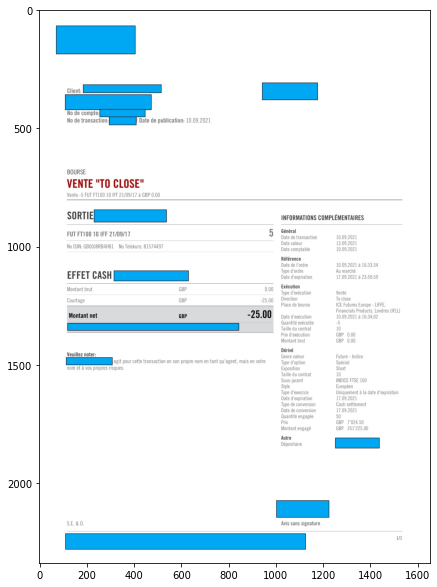

In [19]:
#read the image from disk
filename = os.path.join(os.getcwd(),'transaction_ticket.jpg')
template = cv2.imread(filename)

# store a copy of the original image
orig = template.copy()

#show the input image
draw(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

### _**Select Relevant RoIs (Regions of Insterest)**_



In [20]:
# define the coordinates of different rois
x_start, x_end = 1165, 1585
y = {'type':(1183,1208),'direction':(1208,1234),'exchange':(1234,1259)}

rois=[]

# loop over the rois coordinates
# select the image region  
# and append a list with the selected rois
for key,val in y.items():
  y_start, y_end = val[0], val[1]
  roi = template[y_start:y_end,x_start:x_end]
  rois.append(roi)

### _**Extract the text from each RoI**_



Vente

To close

ICE Futures Europe - LIFFE,



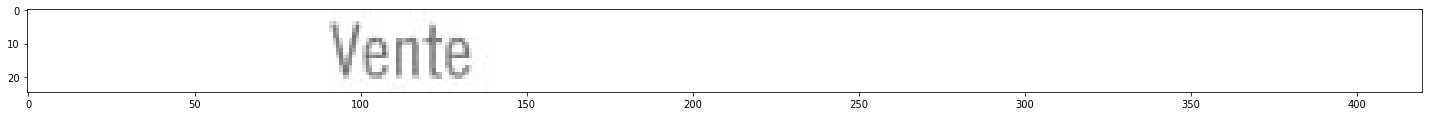

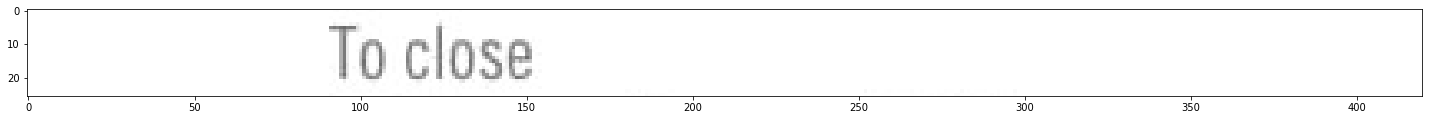

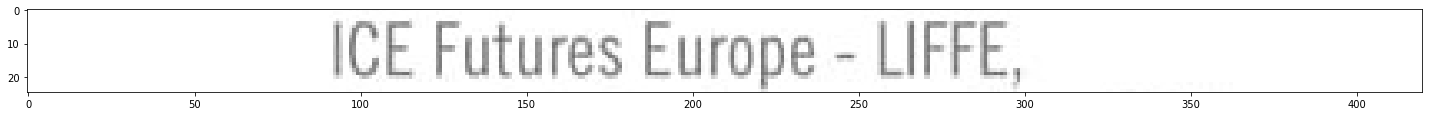

In [21]:
#loop over the selected rois
# draw the roi and extract the text with tesseract
for roi in rois:
  rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
  draw(rgb,(25,7))
  text = pytesseract.image_to_string(rgb)

  for line in text.split("\n"):
      print(line)

##**_Example 2_**
##_Image: a Registration Form and an Invoice_
In this second example, a patient registration form from a famous dental office in Geneva has been submitted. Our system is now taking charge of creating a folder for the patient to store all his relevant documents. Later on, the system receives an invoice that should be stored in the folder that matches the client to whom the invoice was addressed 

We are going read the first name and last name fields in the registration form (with the same methodology of our first example) and create a corresponding folder. After, we are going to extract the same information from the invoice, and try to move the invoice in the corresponding folder.

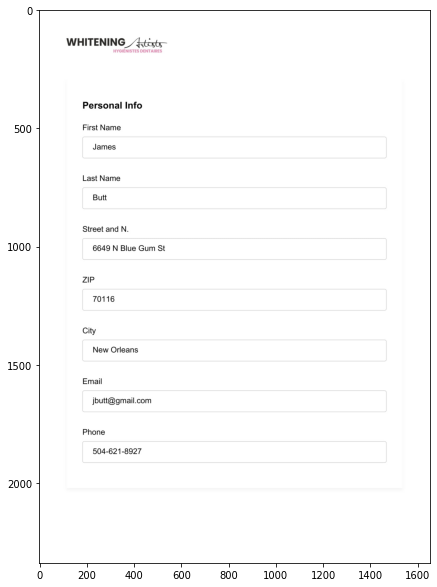

In [22]:
#read the image from disk
filename = os.path.join(os.getcwd(),'registration_ticket.jpg')
template = cv2.imread(filename)

# store a copy of the original image
orig = template.copy()

#show the input image
draw(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

### _**Select Relevant RoIs (Regions of Insterest)**_



In [23]:
# define the coordinates of different rois
x_start, x_end = 200, 1400
y = {'first_name':(545,617),'last_name':(761,822)}

rois=[]

# loop over the rois coordinates
# select the image region  
# and append a list with the selected rois
for key,val in y.items():
  y_start, y_end = val[0], val[1]
  roi = template[y_start:y_end,x_start:x_end]
  rois.append(roi)


### _**Extract the text from each RoI**_




[INFO] Characters after splitting for endline token
[INFO] ['James', '\x0c']
[INFO] ['Butt', '\x0c']

[INFO] creating directory: JamesButt



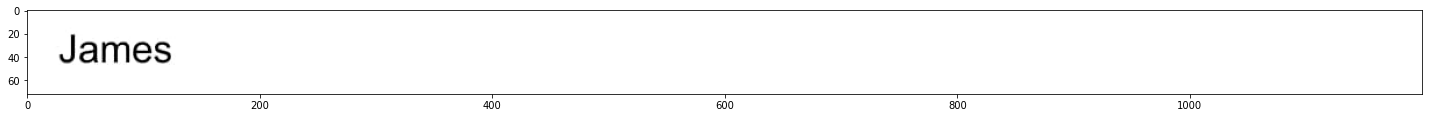

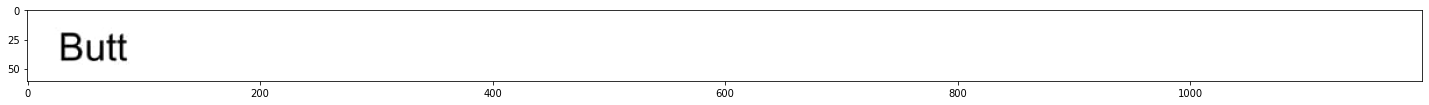

In [24]:
foldername=''
# define a list of forbidden tokens
forbidden_tokens = ['\x0c']

#loop over the selected rois
# draw the roi and extract the text with tesseract
print("\n[INFO] Characters after splitting for endline token")
for roi in rois:
  rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
  draw(rgb,(25,7))
  text = pytesseract.image_to_string(rgb)

  print('[INFO] {}'.format(text.split("\n")))

  #remove the end line token and remove forbidden characters
  for line in text.split("\n"):
      if line and line not in forbidden_tokens: foldername+=line

#creating the directory with os module
print('\n[INFO] creating directory: {}\n'.format(foldername))
os.mkdir(foldername)

Here we see another important feature of Tesseract. As you can see from the output of the string processing, there are some unexpected characters detected `'\x0C`' that, based on [this definition](https://www.computerhope.com/jargon/f/formfeed.htm), is: 

*a special character that, when encountered in code, causes printers to automatically advance one full page or the start of the next page.*

This is a limitation of Tesseract that should be taken in cosideration when designing a Data Science product that should fit a specific case. One possible solution is to explore another method of Tessearct, `image_to_data` instead of `image_to_string`. 

In [25]:
df_text=[]

# get data regarding the text as a dataframe 
# append each dataframe to a list
for roi in rois:
  rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
  df_text.append(pytesseract.image_to_data(rgb, output_type='data.frame')) #Output.DICT

# show one output as example
df_text[0]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1200,72,-1,NaN
1,2,1,1,0,0,0,28,21,96,24,-1,NaN
2,3,1,1,1,0,0,28,21,96,24,-1,NaN
3,4,1,1,1,1,0,28,21,96,24,-1,NaN
4,5,1,1,1,1,1,28,21,96,24,96,James


The image_to data method returns an handy data frame with more information (as the position of the box surrounding the word or the detection confidence). But most importantly there are less strange characters to deal with. From there is easy to extract again the information we need.

In [26]:
foldername=''
for df in df_text:
    for line in df['text'].dropna().to_list():
      if line: foldername+=line

print('\n[INFO] Extracted Folder Name: {}\n'.format(foldername))


[INFO] Extracted Folder Name: JamesButt



### _**Read an Input Invoice**_
we will now repeat the steps for an input invoice.

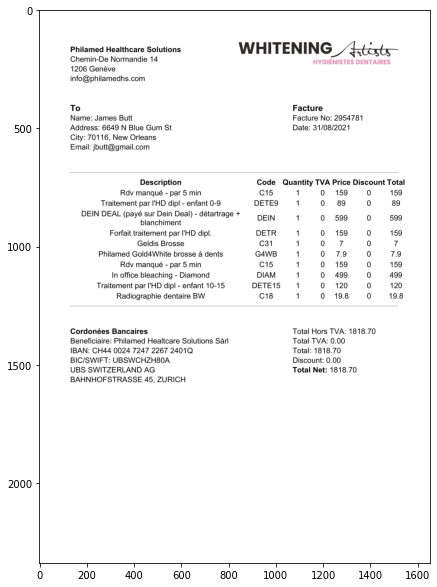

In [27]:
#read the image from disk
filename = os.path.join(os.getcwd(),'invoice_ticket.jpg')
template = cv2.imread(filename)

# store a copy of the original image
orig = template.copy()

#show the input image
draw(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

### _**Extract Text from RoI**_

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,645,160,-1,NaN
1,2,1,1,0,0,0,2,5,428,152,-1,NaN
2,3,1,1,1,0,0,4,5,261,23,-1,NaN
3,4,1,1,1,1,0,4,5,261,23,-1,NaN
4,5,1,1,1,1,1,4,5,89,23,95,Name:
5,5,1,1,1,1,2,106,5,76,23,95,James
6,5,1,1,1,1,3,184,5,81,23,93,Butt
7,3,1,1,2,0,0,2,45,428,112,-1,NaN
8,4,1,1,2,1,0,2,45,428,24,-1,NaN
9,5,1,1,2,1,1,2,45,123,24,96,Address:


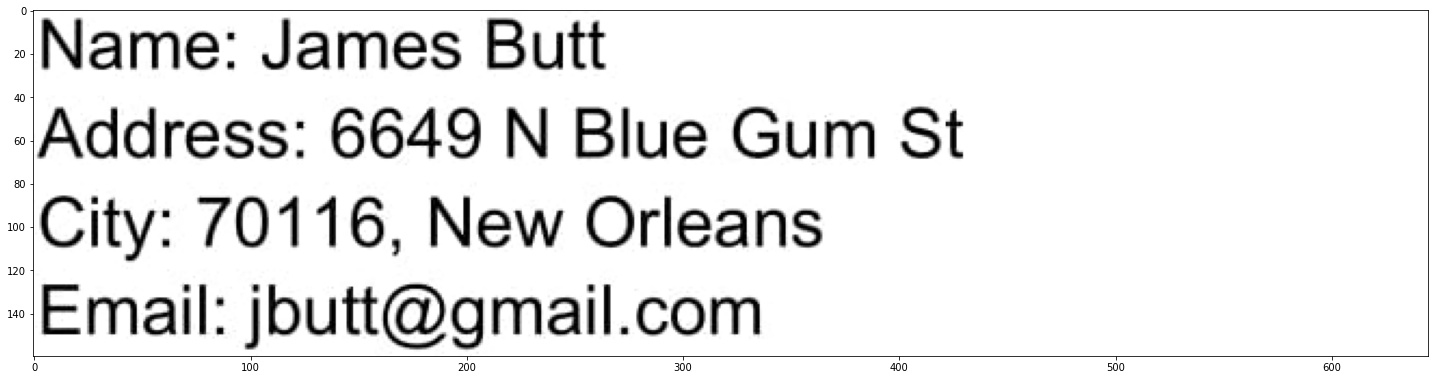

In [28]:
# define the coordinates of different rois
x_start, x_end = 130, 775
y_start, y_end = 440, 600

# select the image region  
roi = template[y_start:y_end,x_start:x_end]

# extract text as a dataframe
rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
draw(rgb,(25,7))
df_text = pytesseract.image_to_data(rgb, output_type='data.frame') #pytesseract.image_to_string(rgb)

df_text

In [29]:
# get a list of strings detected
# find elements between 'Name:' and 'Address:'
# construct the foldername string by joining the resulting list
text_list=df_text['text'].dropna().to_list()
idx_name = text_list.index('Name:')+1
idx_address = text_list.index('Address:')
foldername=''.join(text_list[idx_name:idx_address])

print('\n[INFO] Extracted Folder Name: {}\n'.format(foldername))


[INFO] Extracted Folder Name: JamesButt



### _**Move the invoice to another folder**_

We can now move the invoice to the corresponding folder, adding one more feature: if we cannot find a match between the receiver of the invoice and our folders, we move it to an 'Unmatched' folder. We can also add more actions like sending a notification email or a message when there is no match. 

In this case, the human being enters in the loop by checking the unmatched invoiced and wether the algorithm has failed to detect a correct string. He reports to the error to the IT which will investigate further and improve the algorithm (if possible).

In this way, a positive data loop closes itself, possibly leading to a better model as the time passes.

In [30]:
# create an Unmatched directory if does exist
if os.path.isdir(os.path.join(os.getcwd(),'Unmatched')):
  print('\n[INFO] Unmatched directory already exists\n')
else:
  os.mkdir('Unmatched')

# find all the directories in the current folder and fill a list
a_dir = os.getcwd()
dirlist= [name for name in os.listdir(a_dir) if os.path.isdir(os.path.join(a_dir, name))]

# if the foldername is in the list we move the invoice there
# otherwise we move it to the Unmatched folder

destination = foldername if foldername in dirlist else 'Unmatched'

try:
  shutil.copy(filename, os.path.join(os.getcwd(),destination))
  print("File copied successfully.")
  
# If source and destination are same
except shutil.SameFileError:
  print("Source and destination represents the same file.")
 
# If there is any permission issue
except PermissionError:
    print("Permission denied.")
 
# For other errors
except:
    print("Error occurred while copying file.")

File copied successfully.


If you now browse to the directory (using the File icon in the right menu), you will see that the invoice has been copied to the correct folder. Well done!

## **_Exercise 1_**

<img src="https://drive.google.com/uc?id=10tpXK7FwcLv4NEc9zAyKNDynb-wCVYlb" width="50%">

## _Extract Other Fields in the Invoice or the Transaction Ticket_
Use the invoice or the transaction ticket already dowloaded and the methods described above to extract other relevant fields.

In [31]:
# Use this cell to write your code

<img src="https://drive.google.com/uc?id=1xFbyKxKkx-ljh8n8Y93NLrvG_Y-c_yz5" width="25%">

# **Case 2 - _Difficulty: Novice_**
# _Scanned Document with fixed items position_

We are going now to read a document that was already scanned using Cam Scanner, the famous Android App for document scanning. We repeat the steps applied during **Case 1** . Since the position of the items is still fixed, the methodology of defining RoIs is exactly the same. We will have some differences though, and we will analyse them.

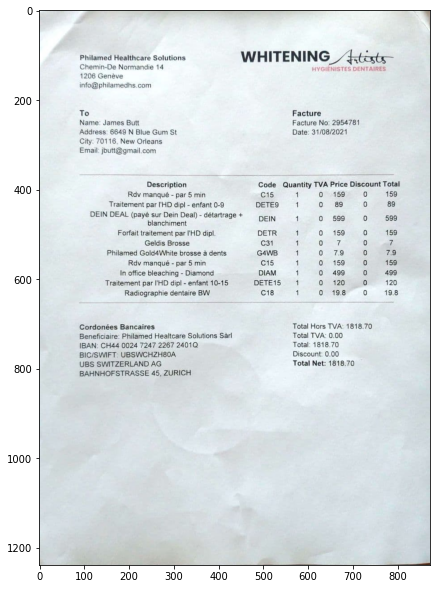

In [32]:
#read the image from disk
filename = os.path.join(os.getcwd(),'invoice_scanned.jpg')
template = cv2.imread(filename)

#show the input image
draw(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

**Very important**: the size of the input image may vary based on the different software/hardware used for scanning the document. In this case, the x,y coordinates of the original RoIs must absolutely be scaled (down or up) to match the image size, otherwise we will end up selecting a different region or we will even get an Error from OpenCV! 

Thus, we can calculte scaling factors for the height and the width of the input RoIs: 

$f_{w}= \frac{w}{w_{original}} $

$f_{h}= \frac{h}{h_{original}} $

where $w,h$ and $w_{original},h_{original}$ are the width and the height of the input image and the original image respectively


[INFO] Extracted Folder Name: JamesButt



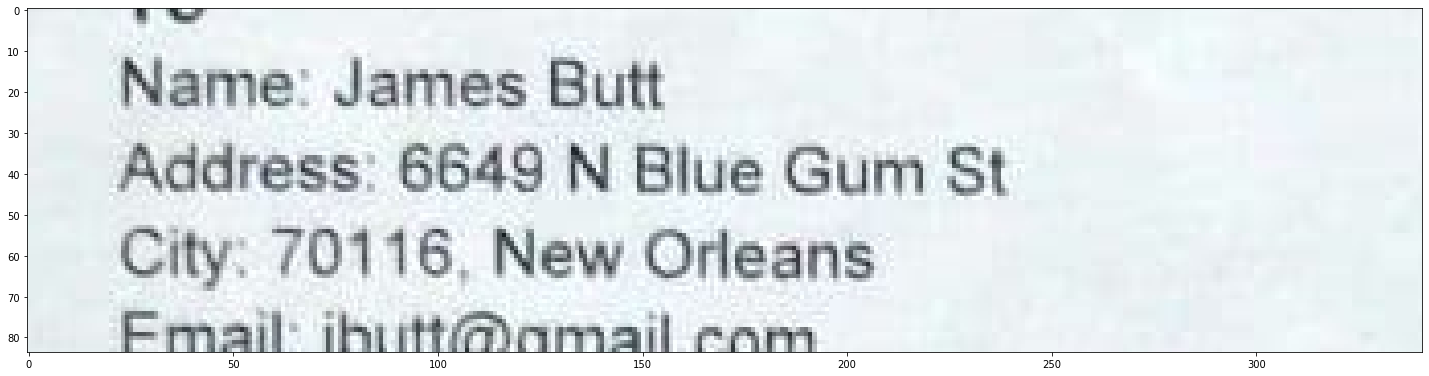

In [33]:

# calculate the resizing factor for the rois
h_orig, w_orig, c_orig = orig.shape 
h, w, c = template.shape 

fh = h/h_orig
fw = w/w_orig  


# define the coordinates of different rois
x_start, x_end = int(130*fw), int(775*fw)
y_start, y_end = int(440*fh), int(600*fh)

# select the image region  
roi = template[y_start:y_end,x_start:x_end]

# extract text as a dataframe
rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
draw(rgb,(25,7))
df_text = pytesseract.image_to_data(rgb, output_type='data.frame') #pytesseract.image_to_string(rgb)

# get a list of strings detected
# find elements between 'Name:' and 'Address:'
# construct the foldername string by joining the resulting list
text_list=df_text['text'].dropna().to_list()
idx_name = text_list.index('Name:')+1
idx_address = text_list.index('Address:')
foldername=''.join(text_list[idx_name:idx_address])

print('\n[INFO] Extracted Folder Name: {}\n'.format(foldername))

As you can see here the are two things to notice:


1.   The RoI now is not centered exactly
2.   The characters are way more blurred than the original image

The blur does not represent a problem in this particular case, Tesseract still can find the information we were looking for. But unfortunately, not all the cases are equal, and there can be situations (documents with poorer quality) where the algorithm fails (as we will see soon).

Also notice that, if we were looking for the email field (i.e. to send an email to the receiver), we would have failed. We would need to find a way to center the content of the RoI.



## **_Exercise 2_**

<img src="https://drive.google.com/uc?id=1QRqDaQGM0FuntcHeppkFZsQyIkTpOSiC" width="40%">

Can you think about a possible solution to the RoI centering problem?

<img src="https://drive.google.com/uc?id=1sjHNgjLOC6d5aErNWPnO4BNPQn6SXSxQ" width="25%">

# **Case 3 - _Difficulty: Master_**
# _Create an homemade scanner_

Sometimes you will face the case when the documents are not just scanned, but are images taken from a camera. In this case, it will be impossible to apply the methodology with RoIs out of the box, because the document paper will never be in the correct position to extract a RoI. We need to process the image in order to align it to the original template. We need therefore to:
 

1.   Detected the countour of the paper in the image
2.   project the contour to a new image with the correct alignment

The procedure is a little bit heavy to work out, but it will be clear in the next section what are the logical passages to apply.

## **_Read Image_**

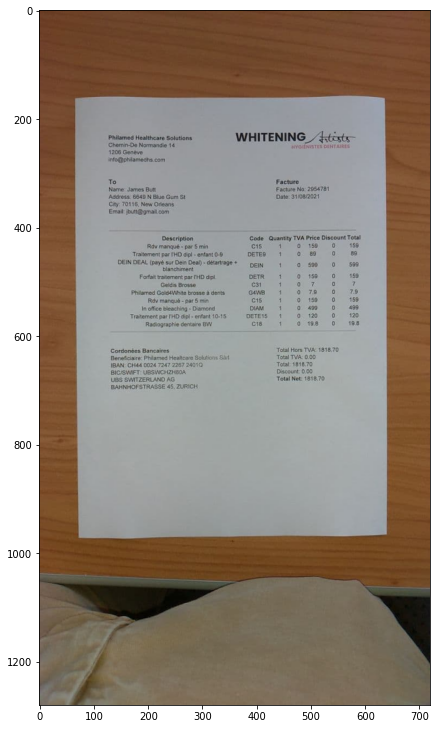

In [34]:
#read the image from disk
filename = os.path.join(os.getcwd(),'invoice_ticket.jpg')
template = cv2.imread(filename)

# Bonus
# upload an image to transform
#uploaded = files.upload()
#uploaded_images = [decode_image(vals) for keys,vals in uploaded.items()]

filename = os.path.join(os.getcwd(),'invoice_test_flash.jpg')
uploaded_image = cv2.imread(filename)

# store a copy of the original image
orig = uploaded_image.copy()

#show the input image
draw(cv2.cvtColor(uploaded_image, cv2.COLOR_BGR2RGB))

As you can see, the image in far from being usable. We need to isolate only the part containing the invoice and try to eliminate the table and the part of my trouser 😅

## **_Perform Edge Detection_**

The logical steps to accomplish this mission are the following:


1.   find all the possible closed shapes in the image
2.   find the shape that has the biggest area and is a rectangle with 4 edges

If we find it, we can safely assume that the shape corresponds to the one of the paper invoice.

The goal is accomplished by the following technique:

*  We apply the [Canny algorithm](https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html) to the image and obatain a mask (a black/withe image) of all the edges.
*   We use the [OpenCV find Contours](https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) function on the mask to obtain all the closed shapes in the image.
* If we don't find anything we repeat the procedure changing the Canny algorithm parameters, until we find a good candidate

For a matter of time, we will not go in deep detail of all the inner mechanisms of all the algorithms involved. The functions we will use are defined in the beginning of the notebook under the section **_Utilites functions_**. You can feel free to investigate more about them if you are interested.






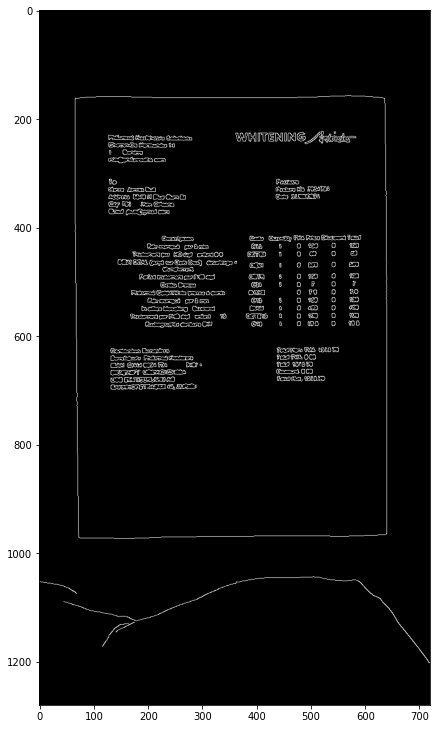

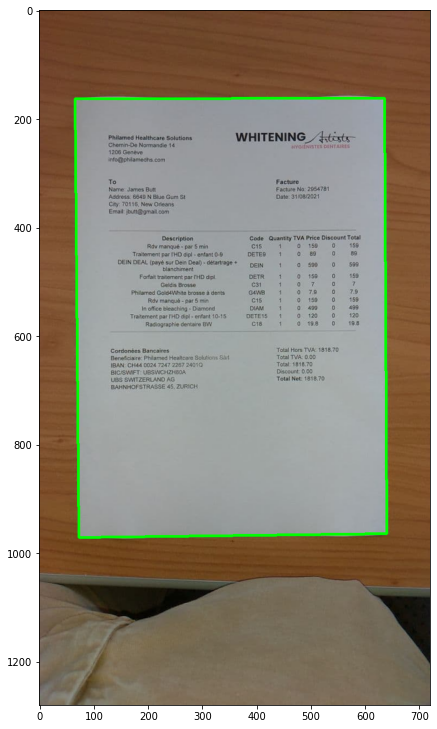

In [35]:
result = autotune_edge_detection(uploaded_image,sigma_init=0.5)
if result:

  # draw edge mask
  edged = result['edge_mask']
  draw(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
  #cv2.imwrite(os.path.join(os.getcwd(),'edged.jpg'),edged)

  # draw contour on the image
  cv2.drawContours(uploaded_image, [result['contour']] , -1, (0, 255, 0), 3)
  draw(cv2.cvtColor(uploaded_image, cv2.COLOR_BGR2RGB))
  #cv2.imwrite(os.path.join(os.getcwd(),'countour.jpg'),uploaded_image)

else:
  print('No contour was found')

## **_Warp the Image_**

We then use the points corresponding to the rectangle we have just found to create a linear trasformation matrix that will map the points of the rectangle to the points of the template invoice. 

This steps are exploited using the function ```four_point_transform``` in the section **_Utilities functions_** and the OpenCV functions: 

```
cv2.getPerspectiveTransform()
cv2.warpPerspective()
  
 ```



True

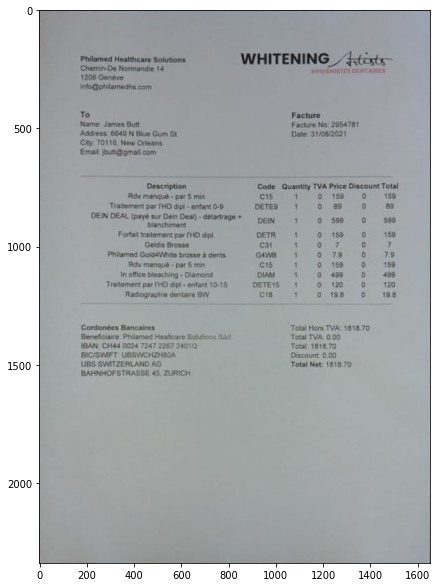

In [36]:
# apply the four point transform to obtain a top-down
# view of the original image using the copy and the edged mask
warped = four_point_transform(orig,template,result['contour'].reshape(4,2))

# draw warped image
draw(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
cv2.imwrite(os.path.join(os.getcwd(),'warped.jpg'),warped)


and bam! 🤯 

We have our image taken from camera aligned. From here on we can again apply our well known technique of text extraction from RoIs, and see what is the output result.

## **_Use Tesseract on Selected RoIs_**

EI Peers. OOml

To

Name: James Butt

Address: 6649 N Blue Gum St
City 70116 New Orleans



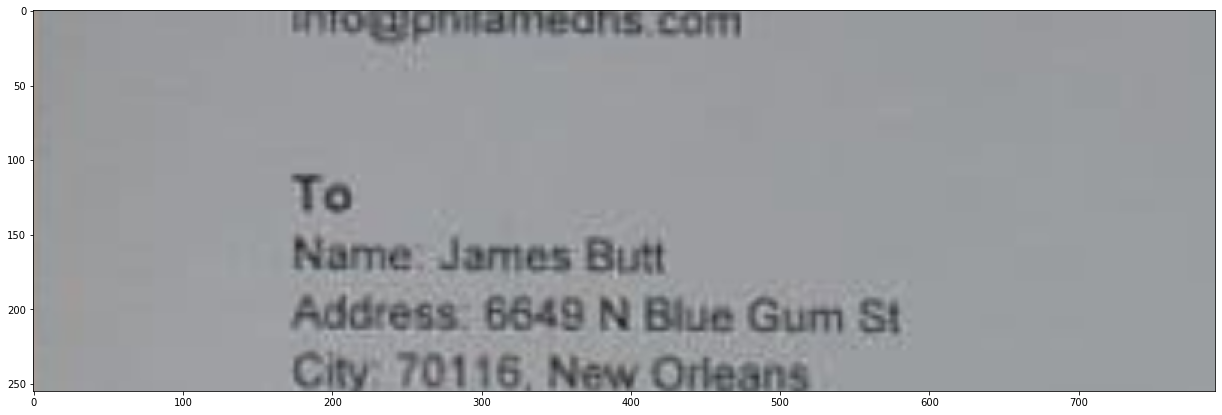

In [37]:
def extract_text_from_roi(warped,key='first_name'):
  # define a dictionary with roi coordinates
  # in the following order
  # 1. (top_left_x,top_left_y) 
  # 2. (bottom_right_x,bottom_right_y)

  # determine a scaling factor between the original template
  # and the warped image
  h_orig, w_orig = 2399,1653
  if len(warped.shape) > 2:
    h_warped, w_warped, c_warped = warped.shape 
  else:
    h_warped, w_warped = warped.shape 

  fh = h_warped/h_orig
  fw = w_warped/w_orig  

  # define a dictionary with the position of the rois
  # in the template image
  rois = {'first_name':[(1,485),(1652,655)],
          'email':     [(1,1240),(1652,1419)],
          'to':        [(1,328),(793,589)]}

  # scale the roi to match
  # the size of the warped image
  tlx = rois[key][0][0]*fw
  tly = rois[key][0][1]*fh
  brx = rois[key][1][0]*fw
  bry = rois[key][1][1]*fh

  # select the corresponding rois in the image
  #aligned = cv2.resize(warped, (w_orig,h_orig), interpolation = cv2.INTER_AREA)
  aligned = warped.copy()
  roi = aligned[int(tly):int(bry),int(tlx):int(brx)]

  # draw the roi and extract the text with tesseract
  rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
  draw(rgb,(25,7))
  text = pytesseract.image_to_string(rgb)
  for line in text.split("\n"):
      print(line)
  
  return text

text=extract_text_from_roi(warped,key='to')

We are still able to extract the information from the RoI but, as you can see, the quality is lowering.

<img src="https://drive.google.com/uc?id=1j615H3PrNo15Jz2Zu0H4jn-N6iu5_EIg" width="25%">

# **Case 4 - _Difficulty: Sith Lord_**
# _Detect Not fixed RoIs using Bounding Box Regression with Deep Learning_

In many situations the position of the regions we are interested to inspect in a document can vary. An example is in the invoices we've been analyzing: the height of table with the products purchased will vary each time, since the number of products is not always the same.

In this case we will not be able at all to extract a RoI and we need some more sophisticated technique. Fortunately we can instruct our machine to detect the position of the RoI, even if it changes every time.

How? with Deep learning of course!

## **_Import Keras and TensorFlow_**

We will be using Keras and Tensor Flow library for the task, so let's import all the relevant stuff

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## **_Read the Annotations_**

To train a model we will need to present it the images of the invoice, and tell it the position of the RoI in each image. We are going to use a json file that has this information and that I have constructed before, using the [VGG Image Annotator](https://www.robots.ox.ac.uk/~vgg/software/via/): a fantastic open source tool for dataset annotation.

The file has all the information we need: file name, position of the RoI (expressed in x,y,height and width).

In [40]:
# download the annotation file
!curl -L "https://docs.google.com/uc?export=download&id=1491L9DVNPMvZdaQwVej81BO_RRGw4MIy" > annotations.json

# load the contents of the json annotations file
print("\n[INFO] reading json annotations...\n")
annotations_json = os.path.join(os.getcwd(),'annotations.json')
with open(annotations_json) as f:
  annotations_dict = json.load(f)

#print some elements of the json
for i in list(annotations_dict.items())[:3]:
  print(i)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    832      0 --:--:-- --:--:-- --:--:--   830
100   99k  100   99k    0     0   138k      0 --:--:-- --:--:-- --:--:--  138k

[INFO] reading json annotations...

('invoice_0.jpg252520', {'filename': 'invoice_0.jpg', 'size': 252520, 'regions': [{'shape_attributes': {'name': 'rect', 'x': 1049, 'y': 1309, 'width': 416, 'height': 264}, 'region_attributes': {'region_label': 'invoice_total'}}], 'file_attributes': {}})
('invoice_1.jpg177297', {'filename': 'invoice_1.jpg', 'size': 177297, 'regions': [{'shape_attributes': {'name': 'rect', 'x': 1029, 'y': 869, 'width': 400, 'height': 264}, 'region_attributes': {'region_label': 'invoice_total'}}], 'file_attributes': {}})
('invoice_2.jpg208326', {'filename': 'invoice_2.jpg', 'size': 208326, 'regions': [{'shape_attributes': {'name': 'rect', 'x': 1029, 'y': 1065

If you look at the 'region_label' attribute you can see that the annotations correspond to the bottom right part of the invoice, were the total amount due is registered. The position of this region in fact varies in each invoice.

## **_Construct the training data_**

We construct the training data by looping over all the filenames and creating 2 arrays:

1.   with all the images
2.   with the coordinates of the Bounding Box



In [42]:
# build path to dataset
dataset_path = os.path.join(os.getcwd(),'AMLD2021','dataset','invoice')

# initialize the lists
data,targets,filenames = [],[],[]

print("\n[INFO] reading images... this may take a while ...\n")

# loop over the keys and values of the json dictionary
for key,val in annotations_dict.items():

  # do not read if there is no region registered
  if len(val['regions']) == 0: continue

  # read the relevant info from the annotations dictionary
  # filename and x,y coordinates of the bounding box
  filename = val['filename']
  startX = val['regions'][0]['shape_attributes']['x']
  startY = val['regions'][0]['shape_attributes']['y']
  endX = startX + val['regions'][0]['shape_attributes']['width'] #startx + width
  endY = startY + val['regions'][0]['shape_attributes']['height'] #starty + height

  # build the path to the image and read it
  image_path = os.path.join(dataset_path,filename)
  image = cv2.imread(image_path)

  # skip if there was a problem loading the image
  if image is None: continue

  # scale the bounding box coordinates relative to the spatial
  # dimensions of the input image
  (h, w) = image.shape[:2]
  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h
  
  # load the image and preprocess it
  # scale to 224 x 224 the input size for VGG16
  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image)
	
  # update our list of data, targets, and filenames
  data.append(image)
  targets.append((startX, startY, endX, endY))
  filenames.append(filename)

print("\n[INFO] Read {} total number of images ...\n".format(len(data)))


[INFO] reading images... this may take a while ...


[INFO] Read 436 total number of images ...



### **_Train/Test Split_**

We normalize the images (scale all pixels in the range [0,1]) and use Scikit-Learn  ```train_test_split()``` function and use 10% of the dataset for testing.



In [43]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

## **_Define Model and Compile_**

We are going to use a transfer learning technique to train our model. This means that we will download from Keras a neural network (the [VGG16](https://neurohive.io/en/popular-networks/vgg16/)) that has altready been trained on a huge image dataset ([Imagenet](https://en.wikipedia.org/wiki/ImageNet) in this case).

In order to keep the feature extraction power of the inner layers, we will keep the convulutional layers, but we will change only the otuput Fully Connected layers. The Network will have a 4-neuron output layer, since the have to predict 4 numbers.

We the handy Keras functional API to do the magic. 🧙‍♂️

In [44]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 1e-5
EPOCHS = 30
BS = 32

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers
baseModel.trainable = False

# flatten the max-pooling output of VGG
flatten = baseModel.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=bboxHead)

# compiling the model
# we use the mean square error 
# a very common loss for regression problems
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())


58900480/58889256 [==============================] - 1s 0us/step
[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________

## **_Train Model_**


[INFO] training bounding box regressor...

Epoch 1/30
13/13 [==============================] - 50s 828ms/step - loss: 0.0422 - val_loss: 0.0213
Epoch 2/30
13/13 [==============================] - 3s 241ms/step - loss: 0.0153 - val_loss: 0.0097
Epoch 3/30
13/13 [==============================] - 3s 244ms/step - loss: 0.0075 - val_loss: 0.0057
Epoch 4/30
13/13 [==============================] - 3s 245ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 5/30
13/13 [==============================] - 3s 244ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 6/30
13/13 [==============================] - 3s 246ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/30
13/13 [==============================] - 3s 245ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/30
13/13 [==============================] - 3s 245ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/30
13/13 [==============================] - 3s 245ms/step - loss: 9.5076e-04 - val_loss: 8.4537e-04
Epoch 10/30
13/13 [============================

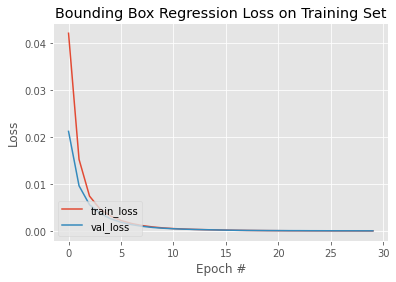

In [45]:
# train the network for bounding box regression
print("\n[INFO] training bounding box regressor...\n")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BS,
    epochs=EPOCHS,
    verbose=1)

# plot the model training history
print("\n[INFO] Drawing the Training Curves...\n\n")
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")


A nice and smooth training Curve after very few Epochs. No sign of overfitting. 

We are know ready to use this model and make some predictions to see if we can extract the RoI we want from some invoices.

## **_Make predictions_**

Always remember. The input image for the prediction should have the exact same size and format that the ones used for training. This is why it is extremely important to reapeat the pre-processing steps before prediciting our RoI position.

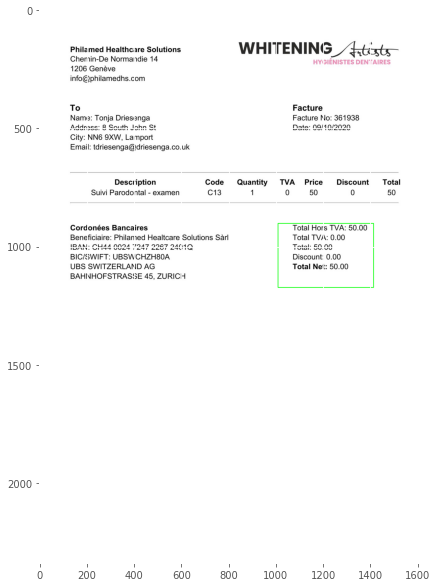

In [50]:
# dowload the test image with curl and subprocess
#
# list of available images:
# 
# https://docs.google.com/uc?export=download&id=1YufQe63RzA04Up9mHhGNf2VpRhztcZoG
# https://docs.google.com/uc?export=download&id=1oUy07v1t-R5h0tAJKGpxzhQ7ALrCHlmx
# https://docs.google.com/uc?export=download&id=1xtNq_HB0u8-oD9NeOjLrs6zlRVOG9ZFp
# https://docs.google.com/uc?export=download&id=1YufQe63RzA04Up9mHhGNf2VpRhztcZoG

urls = ['https://docs.google.com/uc?export=download&id=1YufQe63RzA04Up9mHhGNf2VpRhztcZoG',
        'https://docs.google.com/uc?export=download&id=1oUy07v1t-R5h0tAJKGpxzhQ7ALrCHlmx',
        'https://docs.google.com/uc?export=download&id=1xtNq_HB0u8-oD9NeOjLrs6zlRVOG9ZFp',
        'https://docs.google.com/uc?export=download&id=1YufQe63RzA04Up9mHhGNf2VpRhztcZoG']

url = urls[0]
outname = os.path.join(os.getcwd(),'test.jpg')
subprocess.run(['curl','-L',url,'-o',outname])

# load the input image (in Keras format) from disk and preprocess
# it, scaling the pixel intensities to the range [0, 1]
image = load_img(outname, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# make bounding box predictions on the input image
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds
	
# load the input image and grab its dimensions
test = cv2.imread(outname)
(h, w) = test.shape[:2]
	
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
	
#  draw the predicted bounding box on the image
cv2.rectangle(test, (startX, startY), (endX, endY),(0, 255, 0), 2)
plt.figure(figsize=(7,25))
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))

As you can see, the model has correctly spot the region of the invoice we were looking for. From here we can apply again the methodology of extracting text from RoIs we discussed before, but for the moment ... one last battle before leaving!

## **_Exercise 3_**

<img src="https://drive.google.com/uc?id=1SbIBJfPHw5mIDL7T0QwtN6iQchm_Lm6G" width="50%">

## _**The Last battle: train your own model**_ 

Please follow the instructions:

#### **1.** _Dowload the VGG Image Annotator (VIA) zip file from the [tools folder](https://drive.google.com/file/d/1Wm1pOwJJgfWY78gvwsiDFHwf-r14FSi3/view?usp=sharing) or from the [official site](https://www.robots.ox.ac.uk/~vgg/software/via/), unzip it and open the via.html file with your browser_.

#### **2.** _Dowload the dataset from [here](https://drive.google.com/drive/folders/10xe9yFCkRSPcRfJe3l0M57ltYpSZZg4z?usp=sharing)_.

#### **3.** _Use VIA to_: 
  * Upload the images from _300 on
  * Note the position of the Bounding Box relative to the table of products of the images from _300 on (You can do as much as you want until the end of the dataset _435. I suggest you to do max 50 images for timing reasons)
  * Export the annotations in .json format.

  * (TIP: read the 'help' section in the VIA software)

#### **4.** _Run the cell below and upload the .json annotations you just made: the cell will merge yours with the first _300 that I took last night instead of watching a movie._ 😝


In [51]:
# download annotation json file
url = "https://docs.google.com/uc?export=download&id=1tfGeWrTiFgPsq21ULWcvavEwlBue-6E9"
outname = os.path.join(os.getcwd(),'annotations_invoice_table_0_299.json')
subprocess.run(['curl','-L',url,'-o',outname])

# read first downloaded annotations json from disk 
# as dictionary 
with open(outname) as f:
  annotations_dict = json.load(f)

# upload the json annotation from remote
# and read it as a dictionary
uploaded = files.upload()
data = next(iter(uploaded.values()))
annotations_dict1 = json.loads(data.decode())

# set items in first dictionary equal
# to the elements in the uploaded dictionary
for key,val in annotations_dict1.items():
  if len(val['regions']) > 0:
    annotations_dict[key] = val

# clean the merged dictionary
# eliminate the elements with no region
keys = [key for key,val in annotations_dict.items() if len(val['regions'])==0]
for k in keys: del annotations_dict[k]

Saving invoice_annotation_table_300_310_json.json to invoice_annotation_table_300_310_json.json


#### **5.** _Try to train a bounding box regression model to find the table position using transfer learning._
#### **6.** _Make some predictions on the test images used before._
#### **7.** _Try to extract some information using Tesseract._

# **_Congratulations!_**

<img src="https://drive.google.com/uc?id=1n8MRZfFFlS8NNjSEV1aysp2__qabAzbw" width="50%">

# **_You arrived at the end of the Module_**